<a href="https://colab.research.google.com/github/GalchynskaSofiia/Machine_learning-/blob/main/%D0%9B%D0%A05_%D0%93%D0%B0%D0%BB%D1%8C%D1%87%D0%B8%D0%BD%D1%81%D1%8C%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Лабораторна робота 5. Класифікація. Запобігання перенавчанню. Варіант 4**

**Автор: Гальчинська Софія Володимирівна ФІТ 4-8, була присутня на парі.**

**Лабораторна робота дороблена самостійно, оскільки на парі не встигли закінчити.**



Завантажити датасет з Kaggle. Датасет було отримано за посиланням: https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset?select=diabetes_prediction…

Провести попередній аналіз і підготовку даних. Перевірити наявність пропущених даних, дублікатив, попарну кореляцію, кореляцію з цільовою змінною. Перевірити симетричність розподілу, балансування класів. Побудувати моделі models = { 'LogisticRegression': LogisticRegression(), 'RidgeClassifier': RidgeClassifier(), 'SGDClassifier': SGDClassifier(), 'SVC': SVC() }

Вивести класифікаційний звіт, матрицю плутанини. Підібрати оптимальні параметри HalvingGridSearchCV Вивести оптимальні параметри Вивести класифікаційний звіт Вивести 10 випадкових записів з тестової вибірки, справжній і прогнозований клас. Написати висновки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iammustafatz/diabetes-prediction-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'diabetes-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/diabetes-prediction-dataset


In [3]:
df = pd.read_csv(os.path.join(path, "diabetes_prediction_dataset.csv"))
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


Провести дослідження категоріальних ознак.

In [5]:
df.value_counts('gender')

,count
gender,
Female,58552
Male,41430
Other,18


In [6]:
df.value_counts('smoking_history')

,count
smoking_history,
No Info,35816
never,35095
former,9352
current,9286
not current,6447
ever,4004


In [7]:
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1, 'Other': 2})

df['smoking_history'] = df['smoking_history'].map({'No Info': 0,'never': 1, 'former': 2, 'current': 3, 'not current': 4,'ever': 5})

In [8]:
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,1,25.19,6.6,140,0
1,0,54.0,0,0,0,27.32,6.6,80,0
2,1,28.0,0,0,1,27.32,5.7,158,0
3,0,36.0,0,0,3,23.45,5.0,155,0
4,1,76.0,1,1,3,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,0,80.0,0,0,0,27.32,6.2,90,0
99996,0,2.0,0,0,0,17.37,6.5,100,0
99997,1,66.0,0,0,2,27.83,5.7,155,0
99998,0,24.0,0,0,1,35.42,4.0,100,0


Опис стовпців:

**gender** — стать людини (чоловіча/жіноча/інша).

**age** — вік людини у роках.

**hypertension** — наявність гіпертонії (1 — є, 0 — немає).

**heart_disease** — наявність серцевого захворювання (1 — є, 0 — немає).

**smoking_history** — історія куріння (наприклад, ніколи не курив, колишній курець, нині курить тощо).

**bmi** — індекс маси тіла людини (відношення ваги до зросту).

**HbA1c_level** — рівень глікованого гемоглобіну, що показує середній рівень цукру в крові за останні місяці.

**blood_glucose_level** — поточний рівень глюкози в крові.

**diabetes** — наявність діабету (1 — має діабет, 0 — не має).

Вивести типи даних

In [9]:
df.dtypes

,0
gender,int64
age,float64
hypertension,int64
heart_disease,int64
smoking_history,int64
bmi,float64
HbA1c_level,float64
blood_glucose_level,int64
diabetes,int64


Дослідити цільову змінну, виявити чи є дисбаланс класів

In [10]:
df['diabetes'].value_counts()

,count
diabetes,
0,91500
1,8500


Бачимо, що наявний суттєвий дисбаланс: людей без діабету майже в 11 разів більше, ніж з.

Перевірити наявність пропущених даних

In [11]:
df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0


Перевірити на наявність дублікатів, якщо є - видалити

In [12]:
df.duplicated().sum()

np.int64(3854)

In [13]:
df.drop_duplicates(inplace=True)

In [14]:
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,1,25.19,6.6,140,0
1,0,54.0,0,0,0,27.32,6.6,80,0
2,1,28.0,0,0,1,27.32,5.7,158,0
3,0,36.0,0,0,3,23.45,5.0,155,0
4,1,76.0,1,1,3,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99994,0,36.0,0,0,0,24.60,4.8,145,0
99996,0,2.0,0,0,0,17.37,6.5,100,0
99997,1,66.0,0,0,2,27.83,5.7,155,0
99998,0,24.0,0,0,1,35.42,4.0,100,0


Ще раз перевірити баланс цільової змінної

In [15]:
df['diabetes'].value_counts()

,count
diabetes,
0,87664
1,8482


Побудувати гістограму для цільової змінної

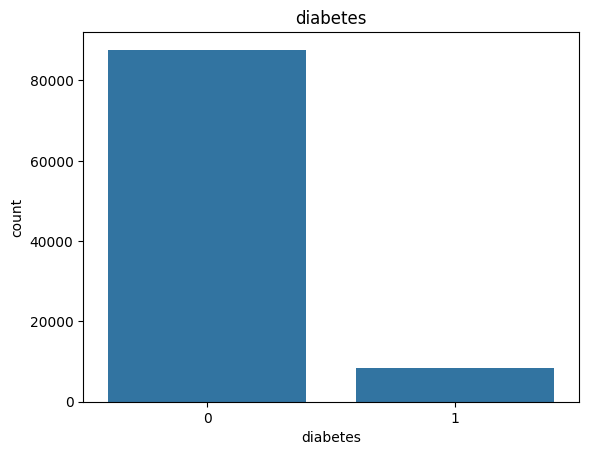

In [16]:
sns.countplot(x='diabetes', data=df)
plt.title('diabetes')
plt.show()

Виявлено значний дизбаланс класів, тож при побудові моделі варто звернути на це увагу.

Вивести статистичні дані про датасет

In [17]:
df.describe()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000
mean,0.416065,41.794326,0.077601,0.040803,1.310975,27.321461,5.532609,138.218231,0.088220
std,0.493287,22.462948,0.267544,0.197833,1.409267,6.767716,1.073232,40.909771,0.283616
min,0.000000,0.080000,0.000000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,0.000000,24.000000,0.000000,0.000000,0.000000,23.400000,4.800000,100.000000,0.000000
50%,0.000000,43.000000,0.000000,0.000000,1.000000,27.320000,5.800000,140.000000,0.000000
75%,1.000000,59.000000,0.000000,0.000000,2.000000,29.860000,6.200000,159.000000,0.000000
max,2.000000,80.000000,1.000000,1.000000,5.000000,95.690000,9.000000,300.000000,1.000000


Перевірити кореляцію із цільовою змінною

In [18]:
df.corrwith(df['diabetes']).sort_values(ascending=False)

,0
diabetes,1.000000
blood_glucose_level,0.424336
HbA1c_level,0.406408
age,0.264927
bmi,0.214932
hypertension,0.195710
heart_disease,0.170711
smoking_history,0.087470
gender,0.037613


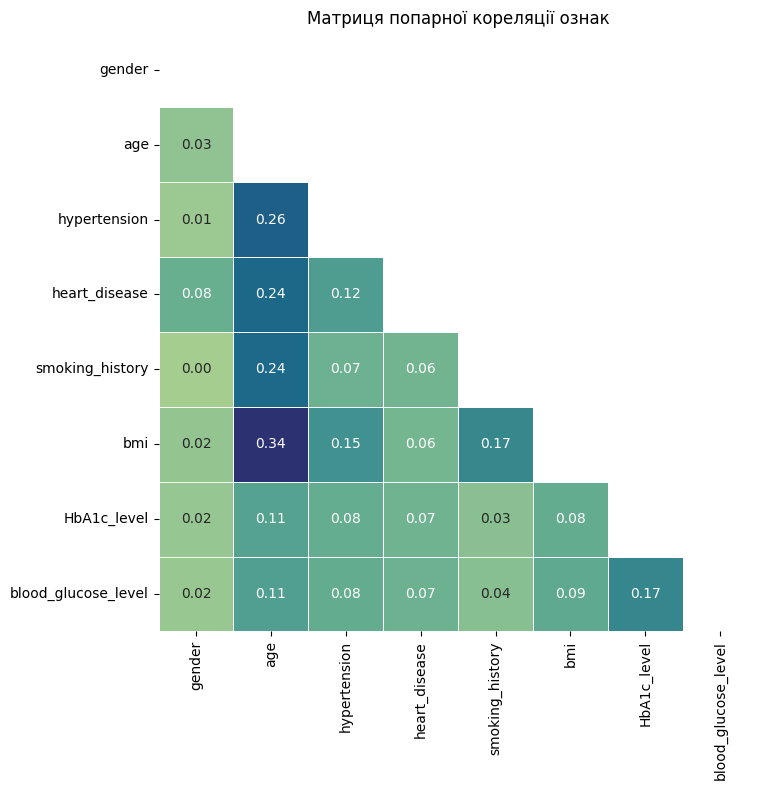

In [19]:
mtx = df.drop('diabetes', axis=1).corr(numeric_only=True).abs()

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(
    mtx,
    annot=True,
    cmap="crest",
    fmt=".2f",
    linewidths=.5,
    mask = np.triu(np.ones_like(mtx, dtype=bool)),
    square=True,
    cbar=False,
    ax=ax
)

plt.title("Матриця попарної кореляції ознак")
plt.tight_layout()
plt.show()

Оскільки немає щільної попарної кореляції ознак, видаляти нічого не будемо.

Перевіримо на викиди

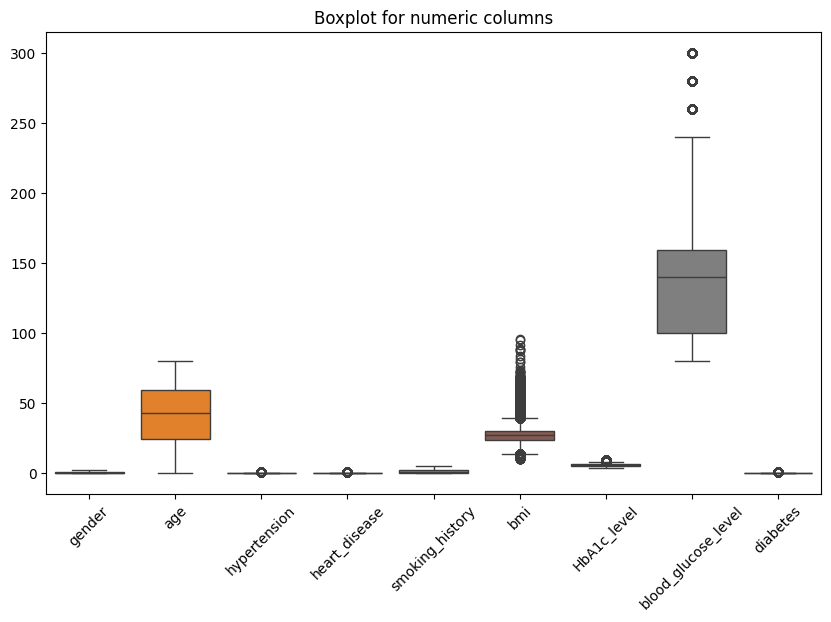

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title("Boxplot for numeric columns")
plt.show()

Так, викиди присутні, але ми видаляти їх не будемо.

Побудувати моделі models = { 'LogisticRegression': LogisticRegression(), 'RidgeClassifier': RidgeClassifier(), 'SGDClassifier': SGDClassifier(), 'SVC': SVC() }

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
#відокремлення ознак від цільової змінної
X = df.drop('diabetes', axis=1)
y = df['diabetes']

In [23]:
#розбиття на навчальні і тестові дані.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=500),
    'RidgeClassifier': RidgeClassifier(),
    'SGDClassifier': SGDClassifier(),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"=== {name} ===")
    print("Класифікаційний звіт:")
    print(classification_report(y_test, y_pred))
    print("Матриця плутанини:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")

=== LogisticRegression ===
Класифікаційний звіт:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17509
           1       0.85      0.63      0.72      1721

    accuracy                           0.96     19230
   macro avg       0.91      0.81      0.85     19230
weighted avg       0.95      0.96      0.95     19230

Матриця плутанини:
[[17323   186]
 [  643  1078]]


=== RidgeClassifier ===
Класифікаційний звіт:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     17509
           1       0.99      0.30      0.46      1721

    accuracy                           0.94     19230
   macro avg       0.96      0.65      0.72     19230
weighted avg       0.94      0.94      0.92     19230

Матриця плутанини:
[[17504     5]
 [ 1199   522]]


=== SGDClassifier ===
Класифікаційний звіт:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     

In [25]:
#Для побудови моделі по методу опорних векторі необхідно спочатку нормалізувати дані, а потім відокремлювати їх на навчальні і тестові вибріки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [26]:
svm = SVC(kernel='rbf', C=1.0, gamma='scale')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

# Виведення результатів
print("=== SVC ===")
print("Класифікаційний звіт:")
print(classification_report(y_test, y_pred))
print("Матриця плутанини:")
print(confusion_matrix(y_test, y_pred))

=== SVC ===
Класифікаційний звіт:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     17509
           1       0.97      0.58      0.73      1721

    accuracy                           0.96     19230
   macro avg       0.97      0.79      0.85     19230
weighted avg       0.96      0.96      0.96     19230

Матриця плутанини:
[[17483    26]
 [  724   997]]


Підібрати оптимальні параметри HalvingGridSearchCV, вивести їх. Вивести класифікаційний звіт

In [27]:
#підбір оптимальних параметрів
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

param_grids = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': [None, 'balanced']
    },
    'RidgeClassifier': {
        'alpha': [0.001, 0.01, 0.1, 1, 10]
    },
    'SGDClassifier': {
        'loss': ['hinge', 'log_loss', 'modified_huber'],
        'penalty': ['l2', 'l1', 'elasticnet'],
        'alpha': [1e-4, 1e-3, 1e-2]
    }
}

In [28]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=2000, random_state=42),
    'RidgeClassifier': RidgeClassifier(random_state=42),
    'SGDClassifier': SGDClassifier(random_state=42, max_iter=2000)
}

In [29]:
#налаштування крос-валідації (оскільки класи незбалансовані, то використовувати просто cv = 3, як для задач регресії, не раціонально)
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [30]:
results = {}

for name, model in models.items():
    print(f"\n HalvingGridSearch для {name}...")

    grid = HalvingGridSearchCV(estimator=model,
                        param_grid=param_grids[name],
                        scoring='f1', #f1 найкраща метрика, коли модель має незбалансовані класи
                        cv=cv,
                        factor=2,
                        n_jobs=1,
                        verbose=1
                               )
    grid.fit(X_train, y_train)

    best_params = grid.best_params_
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)

    report = classification_report(y_test, y_pred)

    results[name] = {
        "best_params": best_params,
        "best_estimator": best_model,
        "y_pred": y_pred,
        "classification_report": report
    }

    print("Найкращі параметри:", best_params)
    print("Найкращий середній F1-score (CV):", grid.best_score_)
    print("\nКласифікаційний звіт:", report)


 HalvingGridSearch для LogisticRegression...
n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 2403
max_resources_: 76916
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 32
n_resources: 2403
Fitting 3 folds for each of 32 candidates, totalling 96 fits
----------
iter: 1
n_candidates: 16
n_resources: 4806
Fitting 3 folds for each of 16 candidates, totalling 48 fits
----------
iter: 2
n_candidates: 8
n_resources: 9612
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 3
n_candidates: 4
n_resources: 19224
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 4
n_candidates: 2
n_resources: 38448
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 5
n_candidates: 1
n_resources: 76896
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Найкращі параметри: {'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Найкращий середній F1-score (C

Після підбору оптимальних параметрів та виведення результатів можна зробити висновок, що найкращу якість моделі продемонструвала логічстична регресія, оскільки метрика F1, яка є найбільш точною для моделей з незбалансованими класами, тут є найвищою і становить 0.73. Також високий показник F1 (становить 0.729) має модель SGD-класифікатор. Натомість Ridge-класифікатор виявився менш придатним для задачі класифікації із незбалансованими класами і показав значно нижчі результати (F1 становить 0.475)

Вивести 10 випадкових записів з тестової вибірки, справжній і прогнозований клас.

In [35]:
for name, res in results.items():
    df_compare = pd.DataFrame({
        "Справжній клас": y_test,
        "Прогнозований клас": res["y_pred"]
    })

    print(f"\n{name} — 10 випадкових записів:")
    print(df_compare.sample(10, random_state=42))


LogisticRegression — 10 випадкових записів:
       Справжній клас  Прогнозований клас
71924               0                   0
3199                0                   0
93254               0                   0
64409               0                   0
19658               0                   0
39490               0                   0
48799               0                   0
43070               0                   0
2107                0                   0
24985               0                   0

RidgeClassifier — 10 випадкових записів:
       Справжній клас  Прогнозований клас
71924               0                   0
3199                0                   0
93254               0                   0
64409               0                   0
19658               0                   0
39490               0                   0
48799               0                   0
43070               0                   0
2107                0                   0
24985               0          

Оскільки у датасеті наявні 2 класи (0 - здоровий, 1 - хворий на діабет) і дані класи незбалансовані (здорових у 10 разів більше), то ймовірність, що більшість випадкових рядків, де усі здорові, дуже висока.

Про всяк випадок перевіримо, чи моделі здатні прогнозувати клас 1 (хворі на діабет).

In [36]:
for name, res in results.items():
    unique, counts = np.unique(res["y_pred"], return_counts=True)
    print(f"{name}: {dict(zip(unique, counts))}")

LogisticRegression: {np.int64(0): np.int64(17966), np.int64(1): np.int64(1264)}
RidgeClassifier: {np.int64(0): np.int64(18703), np.int64(1): np.int64(527)}
SGDClassifier: {np.int64(0): np.int64(18038), np.int64(1): np.int64(1192)}


Бачимо, що моделі все ж таки виявляють випадки діабету, клас 1, але таких передбачень мало через значний дисбаланс класів.

**Висновки:** Отже, під час виконання данох лабораторної роботи було досліджено задачу бінарної класифікації на основі даних отриманих з датасету "Прогнозування діабету". Проведено попередній аналіз даних, а саме: перевірка наявністості пропущених значень, дублікативів, досліджено кореляції між ознаками та цільовою змінною, а також збалансованість класів.

Для вирішення задачі створено 4 класифікаційні моделі: логістична регресія, Ridge- та SGD-класифікатори та метод опорних векторів. Для кожної моделі здійснено підбір оптимальних параметрів за допомогою методу HalvingGridSearchCV, що дозволило підвищити якість класифікації.

Після аналізу отриманих результатів можна сказати, що найкращий показник F1 продемонстрували моделі лінійної регресії та SGD-класифікатор. Порівняння здійснювалось саме на основі метрики F1, оскільки вона є найоб'єктивнішою для випадків, коли наявний значний дисбаланс класів.